Goal : see correlations between lags

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
import gc
import json


In [13]:
Positive_Deliveries = True #Set 0 for negative deliveries
weekend0 = True #Set 0 for positive deliveries during the weekend
Remove_RareOccurences=True
Remove_Outliers=False
AdaptativeFirstDate=False
clear_small_Deliveries=True
forecast_start = pd.Timestamp("2025-01-01")
forecast_end   = pd.Timestamp("2025-05-31")

In [14]:
# ---------------------------
# Config: lags & rollings
# ---------------------------
#SHORT_LAGS      = [1,2,3,4,5,6,7,8,9,10]
#WEEKDAY_LAGS    = [7,14,21,28,35,42,49,56]
#YEARLY_LAGS     = [360,361,362,363,364,365,366,367,368,369,370]
#ALL_LAGS        = sorted(set(SHORT_LAGS + WEEKDAY_LAGS + YEARLY_LAGS))
ROLL_WINDOWS    = [7, 14, 30,365]
ALL_LAGS=range(160,160+1000)
print(ALL_LAGS)

print(pd.Timestamp("2025-05-31")-pd.Timestamp("2024-12-31"))
# I will start with lags -160 and 400 lags (maybe too much, let's see later)

def create_lag_features(data,removeNA=True):
    target = "net_weight"
    d = data

    # --- lag features ---
    lagged_columns = [
        d.groupby("rm_id")[target].shift(lag)
        for lag in ALL_LAGS
    ]
    d = pd.concat([d] + lagged_columns, axis=1)
    d.columns = list(d.columns[:-len(ALL_LAGS)]) + [f"lf_lag_{lag}" for lag in ALL_LAGS]

    # drop first rows with missing lags
    if removeNA:
        d = d.dropna().reset_index(drop=True)

    return d


range(160, 1160)
151 days 00:00:00


In [15]:
# Delete large objects explicitly
if 'daily_receivals' in globals():
    del daily_receivals
if 'd' in globals():
    del d

# Force garbage collection
gc.collect()

receivals = pd.read_csv('../data/kernel/receivals.csv')
print(len(receivals["rm_id"].unique()))
receivals = receivals.dropna(subset=["net_weight"])
receivals = receivals[receivals["net_weight"] > 0]

receivals['date_arrival'] = (
    pd.to_datetime(receivals['date_arrival'], utc=True)
      .dt.tz_localize(None)
      .dt.normalize()
)

daily_receivals = (
    receivals.groupby(["rm_id","date_arrival"], as_index=False)
             .agg(
                 net_weight_sum=("net_weight", "sum")
             ).rename(columns={"date_arrival": "date","net_weight_sum":"net_weight"})
             .sort_values(["rm_id","date"])
)

if Remove_RareOccurences:
    stats = (
        daily_receivals.groupby("rm_id")
                .agg(
                    last_delivery=("date", "max"),
                    total_deliveries=("date", "count")  # number of delivery-days
                )
    )
    cutoff = pd.Timestamp("2024-12-31") - pd.DateOffset(years=2)
    cond1 = (stats["last_delivery"] <= cutoff) & (stats["total_deliveries"] <= 30 )
    cond2 =(stats["last_delivery"] <= pd.Timestamp("2006-01-01"))
    rare_rm_id = stats.index[cond1 | cond2]
    print(f"We don't have enough information to forecast the following rm_id :\n{rare_rm_id}")
    print(f"number :  {len(rare_rm_id)}")
    
    # I remove rare_rm_id 
    daily_receivals = daily_receivals[~daily_receivals["rm_id"].isin(rare_rm_id)].reset_index(drop=True)

print(f"number of deliveries {len(daily_receivals)}")

full_start = pd.Timestamp("2004-01-01")
full_end   = pd.Timestamp("2024-12-31")
rm_ids = pd.Index(daily_receivals["rm_id"].unique(), name="rm_id")
calendar = pd.date_range(full_start, full_end, freq="D", name="date")
full_idx = pd.MultiIndex.from_product([rm_ids, calendar], names=["rm_id","date"])

daily_receivals = (
    daily_receivals.set_index(["rm_id","date"])["net_weight"]
         .reindex(full_idx, fill_value=0)
         .reset_index()
)

daily_receivals["net_weight"] = daily_receivals["net_weight"].astype('float32')
daily_receivals=create_lag_features(daily_receivals)
daily_receivals = daily_receivals.sort_values(["rm_id","date"]).reset_index(drop=True)
#print(daily_receivals.columns)
print(f"number of rows {len(daily_receivals)}")
daily_receivals=daily_receivals.drop(columns=["rm_id","date"])


204
We don't have enough information to forecast the following rm_id :
Index([ 342.0,  343.0,  345.0,  346.0,  347.0,  348.0,  353.0,  354.0,  355.0,
        357.0,  358.0,  360.0,  362.0,  364.0,  365.0,  366.0,  367.0,  368.0,
        369.0,  374.0,  375.0,  378.0,  379.0,  380.0,  381.0,  383.0,  387.0,
        388.0,  389.0,  390.0, 1842.0, 1843.0, 1844.0, 1845.0, 1846.0, 1850.0,
       1851.0, 1852.0, 1853.0, 1854.0, 1857.0, 1858.0, 1866.0, 1867.0, 1868.0,
       1871.0, 1872.0, 1873.0, 1874.0, 1882.0, 1981.0, 2001.0, 2061.0, 2102.0,
       2121.0, 2122.0, 2128.0, 2139.0, 2141.0, 2148.0, 2156.0, 2158.0, 2201.0,
       2223.0, 2282.0, 2283.0, 2285.0, 2302.0, 2304.0, 2322.0, 2323.0, 2341.0,
       2343.0, 2344.0, 2345.0, 2347.0, 2348.0, 2362.0, 2363.0, 2402.0, 2421.0,
       2481.0, 2521.0, 2561.0, 2742.0, 2821.0, 2841.0, 2861.0, 3022.0, 3101.0,
       3144.0, 3222.0, 3241.0, 3481.0, 3501.0, 3541.0],
      dtype='float64', name='rm_id')
number :  96
number of deliveries 40321
number

In [16]:
corr_matrix = daily_receivals.corrwith(daily_receivals['net_weight']).sort_values(ascending=False)

In [26]:

corr_matrix.to_csv('correlations_ordered.csv')

net_weight     1.000000
lf_lag_364     0.715460
lf_lag_231     0.696749
lf_lag_238     0.693209
lf_lag_371     0.690540
                 ...   
lf_lag_1138    0.259492
lf_lag_1131    0.259466
lf_lag_1152    0.258757
lf_lag_1159    0.258041
lf_lag_1145    0.255749
Length: 1001, dtype: float64


C:\Users\julie\AppData\Local\Temp\ipykernel_5820\1758568982.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr, y=top_corr.index, palette='coolwarm')


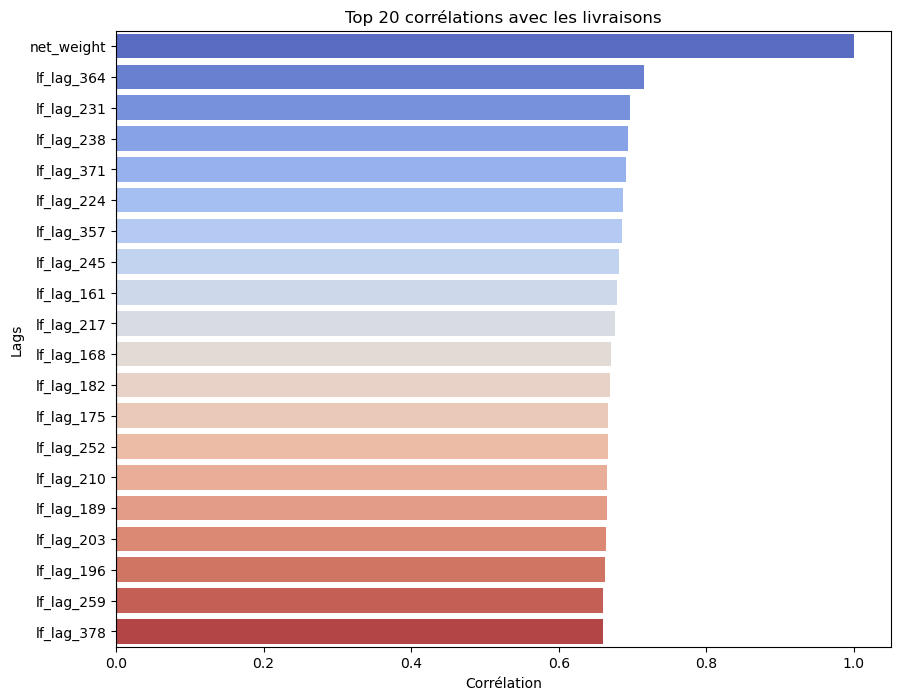

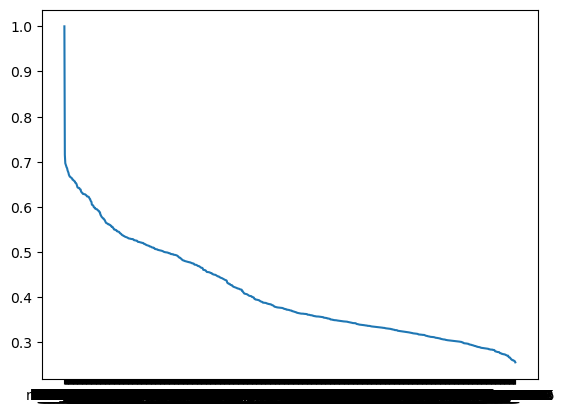

In [21]:
print(corr_matrix)
# Sélectionner les top N corrélations (ex: top 20)
top_n = 20
top_corr = corr_matrix.head(top_n)

# Tracer un barplot horizontal
plt.figure(figsize=(10, 8))
sns.barplot(x=top_corr, y=top_corr.index, palette='coolwarm')
plt.title(f"Top {top_n} corrélations avec les livraisons")
plt.xlabel("Corrélation")
plt.ylabel("Lags")
plt.axvline(0, color='black', linestyle='--')  # Ligne à 0 pour repère
plt.show()

plt.plot(corr_matrix)

In [ ]:
lags_to_keep = corr_matrix[corr_matrix>= 0.5] 
lags_to_keep = lags_to_keep.drop(["net_weight"])
lag_numbers = lags_to_keep.index.str.replace('lf_lag_', '', regex=False).astype(int).to_list()



with open("list_lags.txt", "w") as f:
    json.dump(lag_numbers, f)